In [1]:
!pip install pyswarms

     |████████████████████████████████| 102kB 2.5MB/s 


In [2]:
import pyswarms as ps

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import time

from scipy.integrate import odeint,simps

In [3]:
Cva=0.0824 #kmol/m3
Cbv=1.5324 #kmol/m3
Ccv=0 #kmol/m3
q=0.0720 #m3/min
qc=0.6307  #m3/min
ro=974.19 #kg/m3
roc=998 #kg/m3
Cp=3.7187 #kJ/(kg*K)
Cpc=4.182#kJ/(kg*K)
V=2.407 #m3
Vc=2 #m3
A=8.695 #m2
alpha=13.8 #kJ/(min*m2*K)
Tv=299.05 #K
Tvc=288.15 #K
g=10183 #K
DrH=-5.46e6 #kJ/kmol
kinf=2.8233e11 #min-1

#Inicialmente....
Ca=Cva
T=Tv
Tc=Tvc
#Leitura dos dados
data=pd.read_csv('Dados_gerados_case_geral_t_2_v2', sep='\t', encoding='utf-8',header=None)

data.columns=['Tvc_','T_','Tvc_t-1','T_t-1','Tvc_t-2','T_t-2']

#data=data.drop(['qc_','Tv_','Tvc_','q_'],axis=1)

data=data.dropna()

#---------------------------------------------------------------------------------------


#Definição de targets

#target_tc=data.pop('Tc_')
#target_ca=data.pop('Ca_')
target=data.pop('T_')
_=data.pop('Tvc_')
#Padronização dos dados
scaler=StandardScaler()

entrada=scaler.fit_transform(data)

2020-12-19 16:22:18,275 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [ ]:
#model = tf.keras.models.load_model('Treino_MLP_v2.h5')
model = tf.keras.models.load_model('Treino_RNN_v2.h5')

In [ ]:



def J(u):   
    """
    u=Tvc[t-1,t,t+1]
    model = rede neural treinada
    h_pred = horizonte de predição
    h_contr = horizonte de controle
    SP = Set-point
    """
    global model,h_pred,SP,Tvc_t_1,T_t_1,Tvc_t_2,T_t_2,T_t_1_,T_,Tvc_t_2_,T_t_2_,T_t_1_
    #Parâmetro referente ao controlador (verificar artigos)
    wT=0.1
    lambda_q=10

#    start_time = time.time()
#    Loop para cálculo do horizonte de predição
    
    #Informação do Tvc para ser utilizado no df 'd_Tvc'
    Tvc_t_2_=Tvc_t_2
    
    T_t_2_=T_t_2
    T_t_1_=T_t_1
    
    T_=[]
    
    for i in range(h_pred):
        
        if i<3:
          
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[i],
                                                                                   T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[i]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
        else:
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[3],
                                                                               T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[3]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
#    print("--- %s seconds ---" % (time.time() - start_time))
   
    #Array com os set points no decorrer da predição
    y_ref=[SP]*h_pred
    
    #Horizonte de controle (3)
    d_Tvc=[]
    d_Tvc.append((u[0]-Tvc_t_2_)**2)
    d_Tvc.append((u[1]-u[0])**2)
    d_Tvc.append((u[2]-u[1])**2)
    d_Tvc.append((u[3]-u[2])**2)
    
       
    #função objetivo
    obj=wT*sum((pd.Series(y_ref)-pd.Series(T_))**2)+lambda_q*sum(pd.Series(d_Tvc))
    
    return obj

#EDO do sistema (cstr)
def plant(z,t):
    global q,Cva,V,kinf,g,Tv,alpha,A,ro,Cp,DrH,qc,Tvc,Vc,roc,Cpc
    Ca  = z[0]
    T   = z[1]
    Tc  = z[2]
    
    dCadt=(q*(Cva-Ca)/V)-(kinf*np.exp(-g/T)*Ca)
    dTdt=((Tv-T)*q/V) -(alpha*A*(T-Tc)/(V*ro*Cp))+(kinf*np.exp(-g/T)*Ca*(-DrH)/(ro*Cp))
    dTcdt=(qc*(Tvc-Tc)/Vc)+(alpha*A*(T-Tc)/(Vc*roc*Cpc))
    dzdt = [dCadt,dTdt,dTcdt]
    
    return dzdt


In [ ]:

#FO
qc_t_1=0.6307
Tv_t_1=299.05
Tvc_t_1=288.15
q_t_1=0.072
T_t_1=296.7227
qc_t_2=0.6307
Tv_t_2=299.05
Tvc_t_2=288.15
q_t_2=0.072
T_t_2=296.7227

#Condições iniciais da EDO (partindo do estado estacionário)
Ca=0.0814416
T=296.7227
Tc=288.5237
Tvc=288.15

Tv=299.05 #K
#---------------------
#Entradas - Horizonte de predição e Set-point
h_pred=8
SP=298

z_=[]
z0 = [Ca,T,Tc]
Tvc_=[]
sp_=[]

u=[288.15,288.15,288.15,288.15]
					
def min_f(particles):
        return [J(particle) for particle in particles]
    
    
constraints = (np.array([275,275,275,275]),
               np.array([310,310,310,310]))

In [ ]:
start_time = time.time()
final_step=50
for i in range(final_step):
     
    if i==25:
        SP=297
    
    options={'c1':2,'c2':2,'w':0.5}
    optimizer=ps.single.GlobalBestPSO(n_particles=50,dimensions=4,options=options,bounds=constraints)
    popt=optimizer.optimize(min_f,iters=50)
    
    
    Tvc=popt[1][0]
    Tvc_.append(Tvc)
    #Intervalos de tempo para a integração
    t = np.linspace(0,1,2)
    
    z_.append(np.ndarray.tolist(odeint(plant,z0,t)[1]))
    
    z0=z_[-1]
    
#    Atualização do valor para a próxima iteração
    Tvc_t_2=Tvc_t_1
    Tvc_t_1=Tvc

    
    T_t_2=T_t_1
    T_t_1=z0[1]
    
    u=popt[1]
    
    print(z_)
    print('\n')
    print(T_)
    
    print('\n %.1f %%'%(i*100/final_step))
    print(70*'=')
    
    sp_.append(SP)
    
print("--- %s seconds ---" % (time.time() - start_time))

2020-12-17 18:01:57,327 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.665
2020-12-17 18:03:07,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6650591827580684, best pos: [298.92829733 298.92548817 298.92726178 298.93193361]
2020-12-17 18:03:08,003 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016]]


[296.7694396972656, 296.84637451171875, 296.94384765625, 297.0537109375, 297.1698303222656, 297.28729248046875, 297.40234375, 297.51220703125]

 0.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.607
2020-12-17 18:04:20,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6065588833444848, best pos: [292.91058744 292.91111446 292.90915666 292.90870964]
2020-12-17 18:04:20,673 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993]]


[296.80059814453125, 296.885498046875, 296.98779296875, 297.0992736816406, 297.2148742675781, 297.3302001953125, 297.4419250488281, 297.5476989746094]

 2.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.523
2020-12-17 18:05:37,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5230359696724858, best pos: [298.82769137 298.82467873 298.82635418 298.82782719]
2020-12-17 18:05:37,520 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033]]


[296.857666015625, 296.95147705078125, 297.0585021972656, 297.17236328125, 297.2880554199219, 297.4017639160156, 297.5106201171875, 297.6126708984375]

 4.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.543
2020-12-17 18:06:49,115 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5433771686545992, best pos: [292.13509267 292.19288596 292.22004574 292.20988343]
2020-12-17 18:06:49,128 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279]]


[296.9295654296875, 297.024169921875, 297.1349182128906, 297.2413635253906, 297.3482666015625, 297.4524230957031, 297.5514831542969, 297.643798828125]

 6.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.375
2020-12-17 18:08:00,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.37497953107953197, best pos: [299.39681148 299.39868542 299.40196517 299.39691022]
2020-12-17 18:08:00,414 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187]]


[296.9918518066406, 297.0919189453125, 297.1996154785156, 297.3099060058594, 297.4189453125, 297.5238342285156, 297.62255859375, 297.7137756347656]

 8.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.326
2020-12-17 18:09:11,288 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3256631113151187, best pos: [283.11842926 283.11183522 283.09936703 283.10710142]
2020-12-17 18:09:11,302 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872]]


[297.0614013671875, 297.1576232910156, 297.259521484375, 297.36273193359375, 297.4638977050781, 297.5605773925781, 297.65106201171875, 297.7342529296875]

 10.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.291
2020-12-17 18:10:25,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2914452474748616, best pos: [299.57717949 299.57709151 299.57721204 299.56873003]
2020-12-17 18:10:25,568 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403]]


[297.10833740234375, 297.1975402832031, 297.2939147949219, 297.39300537109375, 297.4912109375, 297.5858459472656, 297.675048828125, 297.7575378417969]

 12.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.266
2020-12-17 18:11:37,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2664946350942138, best pos: [288.53987968 288.53787897 288.53504002 288.53690384]
2020-12-17 18:11:37,986 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144]]


[297.1514892578125, 297.2347717285156, 297.3253173828125, 297.4177551269531, 297.5094909667969, 297.5980224609375, 297.68157958984375, 297.7589416503906]

 14.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.24
2020-12-17 18:12:51,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.24009146040547952, best pos: [288.90626355 288.90864833 288.90650306 288.9063673 ]
2020-12-17 18:12:51,577 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203]]


[297.1959533691406, 297.2731018066406, 297.35809326171875, 297.4458312988281, 297.5332946777344, 297.61798095703125, 297.6980895996094, 297.7724304199219]

 16.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.231
2020-12-17 18:14:03,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.23098854145769698, best pos: [294.74706238 294.7482794  294.74133337 294.73900741]
2020-12-17 18:14:03,779 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132]]


[297.2203063964844, 297.291259765625, 297.3709411621094, 297.454833984375, 297.53948974609375, 297.6222229003906, 297.70111083984375, 297.7747802734375]

 18.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.205
2020-12-17 18:15:16,227 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20545678488877717, best pos: [301.03798559 301.03621523 301.03737094 301.03877815]
2020-12-17 18:15:16,242 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405]]


[297.253173828125, 297.3242492675781, 297.4034118652344, 297.4863586425781, 297.5697326660156, 297.6510009765625, 297.72833251953125, 297.8004150390625]

 20.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.318
2020-12-17 18:16:28,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31820335556480395, best pos: [302.81654984 302.74836496 302.85260538 302.82323432]
2020-12-17 18:16:28,700 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777]]


[297.3195495605469, 297.3928527832031, 297.47210693359375, 297.5486755371094, 297.624267578125, 297.6968688964844, 297.76513671875, 297.8281555175781]

 22.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.633
2020-12-17 18:17:41,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6332658651470369, best pos: [305.33587068 305.23322801 305.11797901 305.17056386]
2020-12-17 18:17:41,763 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631]]


[297.41876220703125, 297.5080261230469, 297.5964050292969, 297.6808166503906, 297.7598876953125, 297.8326416015625, 297.89849853515625, 297.957275390625]

 24.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0482
2020-12-17 18:18:54,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04815569293294514, best pos: [296.86649277 296.8684479  296.86747406 296.86752257]
2020-12-17 18:18:54,370 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176]]


[297.5396423339844, 297.6352233886719, 297.7236328125, 297.80377197265625, 297.8755187988281, 297.9388732910156, 297.99407958984375, 298.04

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.026
2020-12-17 18:20:06,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.025960020416497934, best pos: [289.15928546 289.16272252 289.15339523 289.15702381]
2020-12-17 18:20:06,758 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895]]


[297.64990234375, 297.7394104003906, 297.8195495605469, 297.8904724121094, 2

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.339
2020-12-17 18:21:19,476 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.33878111228246494, best pos: [277.72066865 277.76267596 277.6696731  277.59409447]
2020-12-17 18:21:19,488 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589]]


[297.7109985351

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.793
2020-12-17 18:22:30,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7929727974750236, best pos: [278.46831038 278.41639381 278.47841241 278.66063877]
2020-12-17 18:22:30,941 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0519
2020-12-17 18:23:43,600 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.05188376359205599, best pos: [292.8789381  292.88242956 292.88118931 292.87874872]
2020-12-17 18:23:43,612 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.07
2020-12-17 18:24:53,657 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.07004809994697851, best pos: [291.95543027 291.95642961 291.95337023 291.95276625]
2020-12-17 18:24:53,669 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0737
2020-12-17 18:26:05,289 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.07370697155673545, best pos: [285.16398922 285.17407748 285.16922273 285.16814607]
2020-12-17 18:26:05,306 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0811
2020-12-17 18:27:15,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08112665158810276, best pos: [286.69452913 286.69755897 286.69659578 286.69458439]
2020-12-17 18:27:15,662 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=71.4
2020-12-17 18:28:26,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71.3869802712453, best pos: [306.99373224 308.51855733 309.07445185 306.95446463]
2020-12-17 18:28:26,163 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.102
2020-12-17 18:29:35,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.10155712678409347, best pos: [290.35450831 290.31413237 290.30158999 290.32532062]
2020-12-17 18:29:36,008 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0478
2020-12-17 18:30:47,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04781481382162977, best pos: [293.86429188 293.8617092  293.86202397 293.86246334]
2020-12-17 18:30:47,067 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.22
2020-12-17 18:31:58,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.22012771509378365, best pos: [280.68659144 280.70962099 280.6722587  280.5908592 ]
2020-12-17 18:31:58,906 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.468
2020-12-17 18:33:09,961 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4677068482918164, best pos: [283.30397393 283.29740306 283.30088254 283.29916631]
2020-12-17 18:33:09,977 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.487
2020-12-17 18:34:20,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48740217008893716, best pos: [281.88304188 281.84926269 281.88023252 281.94455391]
2020-12-17 18:34:20,913 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.375
2020-12-17 18:35:30,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.37540071624050597, best pos: [298.48457193 298.52691774 298.48882397 298.46598344]
2020-12-17 18:35:30,948 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=6.62
2020-12-17 18:36:44,417 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.615390291874642, best pos: [305.23539647 305.58176133 304.91225269 305.12934652]
2020-12-17 18:36:44,428 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.431
2020-12-17 18:37:54,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.43120463594578706, best pos: [291.68672956 291.68675164 291.68654584 291.68660841]
2020-12-17 18:37:54,253 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.512
2020-12-17 18:39:04,666 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5121426602046043, best pos: [295.19752492 295.20019571 295.19873748 295.19828695]
2020-12-17 18:39:04,678 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.576
2020-12-17 18:40:16,375 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5756186147064135, best pos: [302.98621614 302.97861225 302.97474807 302.99085895]
2020-12-17 18:40:16,388 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=10.8
2020-12-17 18:41:27,703 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.809687582776359, best pos: [277.45906507 278.08419845 277.82836646 278.14073785]
2020-12-17 18:41:27,714 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.628
2020-12-17 18:42:39,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.627915737567672, best pos: [294.66121342 294.66543853 294.66716153 294.66674566]
2020-12-17 18:42:39,843 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.614
2020-12-17 18:43:51,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6136729391367239, best pos: [301.73128132 301.7302265  301.72443264 301.72147828]
2020-12-17 18:43:51,870 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.666
2020-12-17 18:45:02,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6660342718175659, best pos: [290.76581336 290.76537869 290.76363204 290.76471791]
2020-12-17 18:45:02,108 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.704
2020-12-17 18:46:12,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7042695704345416, best pos: [282.59536694 282.60172709 282.59462019 282.5959118 ]
2020-12-17 18:46:12,740 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.68
2020-12-17 18:47:24,486 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6796144332197191, best pos: [296.05753281 296.06652021 296.06706955 296.0624086 ]
2020-12-17 18:47:24,498 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.67
2020-12-17 18:48:36,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6697647161687282, best pos: [296.01648505 296.02356022 296.02234595 296.0113245 ]
2020-12-17 18:48:36,043 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.702
2020-12-17 18:49:46,411 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7022699366412238, best pos: [289.21149655 289.20979657 289.20823604 289.20829913]
2020-12-17 18:49:46,424 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.724
2020-12-17 18:50:56,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.72427492756337, best pos: [293.07235558 293.07203369 293.07215848 293.07333328]
2020-12-17 18:50:56,710 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.737
2020-12-17 18:52:08,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7367133112350303, best pos: [296.05419883 296.05480501 296.05344868 296.05481026]
2020-12-17 18:52:08,456 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.766
2020-12-17 18:53:19,320 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7664297754786672, best pos: [290.67865119 290.67460602 290.6712459  290.67318105]
2020-12-17 18:53:19,331 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1.02
2020-12-17 18:54:31,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0198814030838328, best pos: [303.12408073 303.19714188 303.2548953  303.14798299]
2020-12-17 18:54:31,465 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.888
2020-12-17 18:55:43,600 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8880563342974849, best pos: [295.87008576 295.87075817 295.86672994 295.86978135]
2020-12-17 18:55:43,613 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.986
2020-12-17 18:56:56,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.9858834468767647, best pos: [294.80630288 294.80194285 294.80444827 294.80706876]
2020-12-17 18:56:56,364 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1.05
2020-12-17 18:58:09,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0515012520690707, best pos: [294.75096762 294.74588994 294.75426915 294.75124274]
2020-12-17 18:58:09,348 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1.07
2020-12-17 18:59:21,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.065172768085134, best pos: [278.80462921 278.78901275 278.78137191 278.80102751]
2020-12-17 18:59:21,554 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1.01
2020-12-17 19:00:34,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0081101285002187, best pos: [294.75243215 294.76064108 294.77300791 294.76586461]
2020-12-17 19:00:34,935 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.941
2020-12-17 19:01:48,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.941233259763464, best pos: [290.81714156 290.81820419 290.81788576 290.81782268]


[[0.08144157791349026, 296.7434375027723, 291.419210000016], [0.08144144485558875, 296.78507085975474, 291.88529949798993], [0.08144115907097814, 296.8418689189189, 293.81059353483033], [0.08144067313007922, 296.90575793563534, 293.398043213279], [0.08143998517304467, 296.976469042971, 295.0528965173187], [0.08143908728263687, 297.0321987328126, 291.8708681324872], [0.08143806043721766, 297.0809451007449, 294.00452405041403], [0.08143688238053919, 297.13112672294835, 292.5745614421144], [0.081435600569436, 297.1636969269345, 291.6451604939203], [0.08143425373518239, 297.1956041702673, 292.5462011113132], [0.08143280599591839, 297.2487679864416, 294.88461839102405], [0.08143116726631117, 297.33022076944724, 297.04484300747777], [0.08142924639160362, 297.4382823831378, 299.276249405631], [0.08142698022936533, 297.55163206573934, 298.6071535164176], [0.08142441763764804, 297.63822134076537, 296.05681976620895], [0.08142170935395772, 297.6702587878951, 291.1507676440589], [0.08141907524365

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
"""
Plotagem dos resultados
"""
p_=pd.DataFrame(z_)

SAVE_RESULTS=p_.copy()
SAVE_RESULTS['sp']=sp_
SAVE_RESULTS['Tvc']=Tvc_


#SAVE_RESULTS.to_csv('Result_RNN_V7.csv', sep='\t', encoding='utf-8', header=None, index=False)


In [ ]:
#Métricas de erro
IAE=simps(abs(sp_-p_[1]))
ISE=simps((sp_-p_[1])**2)
ITAE=simps(np.linspace(0,final_step-1,final_step)*abs(sp_-p_[1]))
ITSE=simps(np.linspace(0,final_step-1,final_step)*((sp_-p_[1])**2))

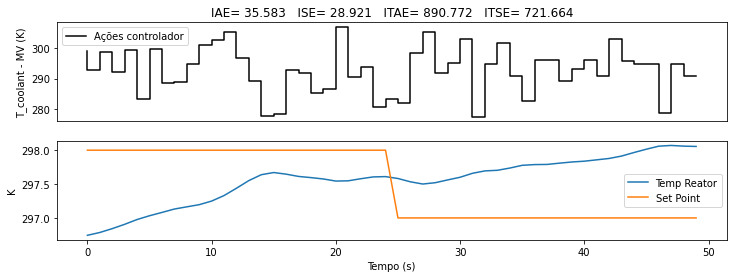

In [ ]:

plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title("IAE= "+'%.3f'%IAE+ "   ISE= "+'%.3f'%ISE+"   ITAE= "+'%.3f'%ITAE+"   ITSE= "+'%.3f'%ITSE)
plt.step(np.linspace(0,final_step-1,final_step),Tvc_,'k',label='Ações controlador')
plt.ylabel('T_coolant - MV (K)')
#plt.xlabel('Tempo (s)')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.legend()


#plt.figure(figsize=(12,4))
plt.subplot(2,1,2)
plt.plot(p_[1],label='Temp Reator')
plt.plot(sp_,label='Set Point')
plt.ylabel('K')
plt.xlabel('Tempo (s)')

plt.xticks(np.linspace(0,final_step,6))
plt.legend()

plt.show()

